In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptune_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptune_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [ ]:
%load_ext autoreload
%autoreload 2

In [442]:
import neptune
import tensorflow as tf
import random

import io
import cirq
import numpy as np
import statistics as st
from matplotlib import pyplot as plt
from collections import defaultdict
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.circuits import get_discriminator
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.quwgans.real_expectations_provider import PrecomputedExpectationsProvider, \
    Interpolation1DExpectationsProvider, WassersteinGanExpectationProvider, ExpectationProviderType
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [472]:
def get_expectation_provider(real, 
                             real_symbols, 
                             known_g_values, 
                             real_values_provider,
                             expectation_provider_type,
                             gen_input_dim=None,
                             hidden_dim=None,
                             penalty_factor=None,
                             gan_epochs=None,
                             batch_size=None,
                             n_crit=None,
                             alpha=None,
                             beta_1=None,
                             beta_2=None):
    precomputed_expectation_provider = PrecomputedExpectationsProvider(real,
                                                                       real_symbols,
                                                                       known_g_values,
                                                                       real_values_provider,
                                                                       get_discriminator(real))
    if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
        return precomputed_expectation_provider
    elif expectation_provider_type == ExpectationProviderType.INTERPOLATION1D:
        return Interpolation1DExpectationsProvider(precomputed_expectation_provider)
    elif expectation_provider_type == ExpectationProviderType.WGAN:
        return WassersteinGanExpectationProvider(precomputed_expectations_provider=precomputed_expectation_provider, 
                                                 gen_input_dim=gen_input_dim, 
                                                 hidden_dim=hidden_dim, 
                                                 penalty_factor=penalty_factor, 
                                                 epochs=gan_epochs, 
                                                 batch_size=batch_size, 
                                                 n_crit=n_crit,
                                                 use_neptune=use_neptune,
                                                 alpha=alpha,
                                                 beta_1=beta_1,
                                                 beta_2=beta_2)

In [473]:
def start_neptune_experiment(use_neptune,
                             trainer, 
                             gen,
                             neptune_params,
                             gan_params,
                             description=None):
    if use_neptune:
        neptune.init(project_qualified_name='wiktor.jurasz/thesis-em-exps', api_token=neptune_token)
        if expectation_provider_type == ExpectationProviderType.WGAN:
            neptune_params = {**neptune_params, **gan_params}
        neptune.create_experiment(name=None, description=description, params=neptune_params)
        neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
        neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

In [474]:
def compute_known_states_stats(tra, g_list):
       return compute_states_stats(
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        g_list,
        g_list
    ) 

def compute_generated_states_stats(tra, g_list):
    return compute_states_stats(
        lambda g: tra.gen_evaluator.get_state_from_params()[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        ["GENERATED"],
        g_list
    )

def compute_states_stats(state_prov1, state_prov2, g_list1, g_list2):
    stats = {
        'min_fidelity': 1,
        'min_fidelity_tuple': (None, None),
        'max_fidelity': 0,
        'max_fidelity_tuple': (None, None),
        'average_fidelity': None,
        'std_fidelity': None
    }
    fids = []
    for g1 in g_list1:
        for g2 in g_list2:
            if g1 != g2:
                state1 = state_prov1(g1)
                state2 = state_prov2(g2)
                fid = cirq.fidelity(state1, state2)
                fids.append(fid)
                if fid < stats['min_fidelity']:
                    stats['min_fidelity'] = fid
                    stats['min_fidelity_tuple'] = (g1, g2)
                if fid > stats['max_fidelity']:
                    stats['max_fidelity'] = fid
                    stats['max_fidelity_tuple'] = (g1, g2)
                
    stats['average_fidelity'] = st.mean(fids)
    stats['std_fidelity'] = st.stdev(fids)
    return stats

In [486]:
def run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     real_expectations_provider,
                     rank,
                     epochs,
                     gen_iteration, 
                     snapshot_interval_epochs,
                     description,
                     use_neptune,
                     neptune_params,
                     gan_params):   
    trainers = {}
    training_results = {}
    for g in g_values:
        trainers[g] = Trainer(real, 
                              real_symbols, 
                              gen, 
                              gs, 
                              [g], 
                              real_values_provider, 
                              real_expectations_provider,
                              rank=rank, 
                              use_neptune=use_neptune)

        opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

        start_neptune_experiment(use_neptune=use_neptune,
                                 trainer=trainers[g], 
                                 gen=gen,
                                 neptune_params=neptune_params,
                                 gan_params=gan_params,
                                 description=description)

        json_result =  trainers[g].train(opt=opt, 
                                         epochs=epochs, 
                                         gen_iteration=gen_iteration, 
                                         snapshot_interval_epochs=snapshot_interval_epochs, 
                                         plot=True)
        training_results[g] = json_result
    
        if use_neptune:
            neptune.stop()
    return trainers, training_results

In [547]:
use_neptune = True
generator_layers = 3
data_bus_size = 5
rank = 1
real_circuit_type = 'butterfly'
generic_generator = False
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.WGAN
known_g_values = list(range(128))
# known_g_values = np.linspace(-1,0,31)
g_values = [4,5,6]

# only relevant if using WGAN provider
gen_input_dim = 32
hidden_dim = [256, 512]
penalty_factor = 10
gan_epochs = 3000
batch_size = 32
n_crit = 7
alpha: float = 0.0001
beta_1: float = 0
beta_2: float = 0.9
        
gen_iteration = 2
snapshot_interval_epochs = 100
epochs = 601

description = None
if expectation_provider_type == ExpectationProviderType.WGAN:
    print(f"Expectations vector size: {9*((data_bus_size * (data_bus_size - 1))/2) + 3 * data_bus_size}")

Expectations vector size: 105.0


In [548]:
neptune_params = {
            'generator_layers': generator_layers,
            'size':  data_bus_size,
            'rank': rank,
            'real_circuit_type': real_circuit_type,
            'generic_generator': generic_generator,
            'zxz': zxz,
            'all_gates_parametrized': all_gates_parametrized,
            'g_values': g_values,
            'expectation_provider_type': expectation_provider_type,
            'known_g_values': known_g_values,
            'gen_iteration': gen_iteration,
            'epochs': epochs
        }

gan_params = {
                'gen_input_dim': gen_input_dim,
                'hidden_dim': hidden_dim,
                'penalty_factor': penalty_factor,
                'gan_epochs': gan_epochs,
                'batch_size': batch_size,
                'n_crit': n_crit,
                'alpha': alpha,
                'beta_1': beta_1,
                'beta_2': beta_2
            }

In [549]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    if real_circuit_type == 'butterfly':
        gen, gs = ButterflyCircuitBuilder("g").build(qubits=qubits)
    else:
        builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
        gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

real_expectations_provider = get_expectation_provider(real, 
                                                      real_symbols, 
                                                      known_g_values, 
                                                      real_values_provider,
                                                      expectation_provider_type,
                                                      gen_input_dim=gen_input_dim,
                                                      hidden_dim=hidden_dim,
                                                      penalty_factor=penalty_factor,
                                                      gan_epochs=gan_epochs,
                                                      batch_size=batch_size,
                                                      n_crit=n_crit,
                                                      alpha=alpha,
                                                      beta_1=beta_1,
                                                      beta_2=beta_2)

<Figure size 432x288 with 0 Axes>

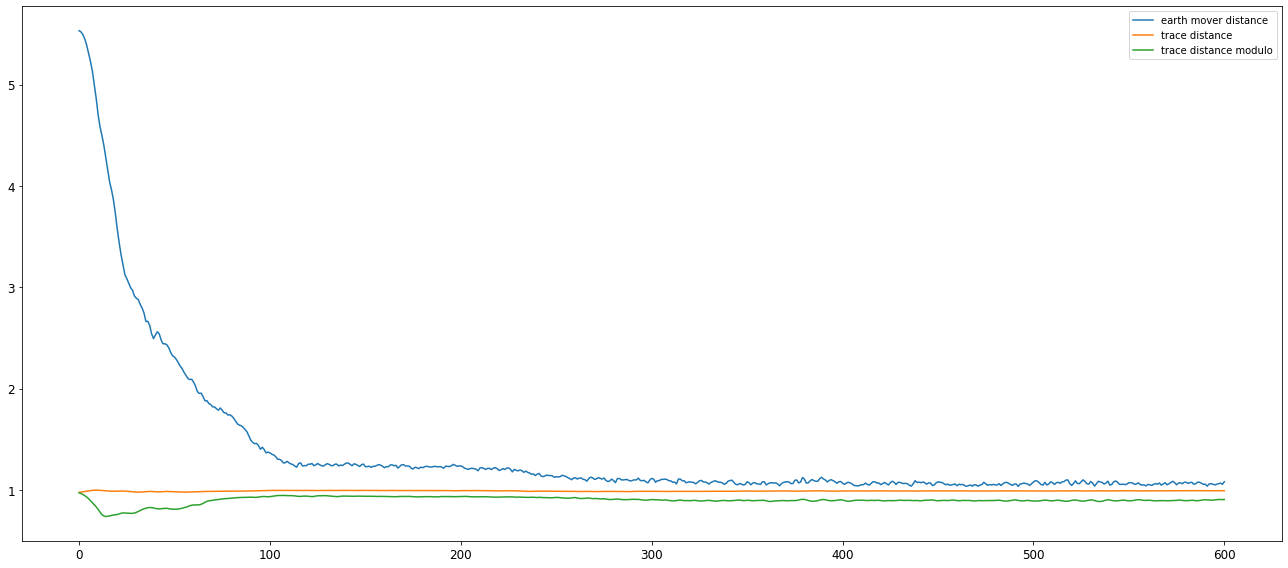

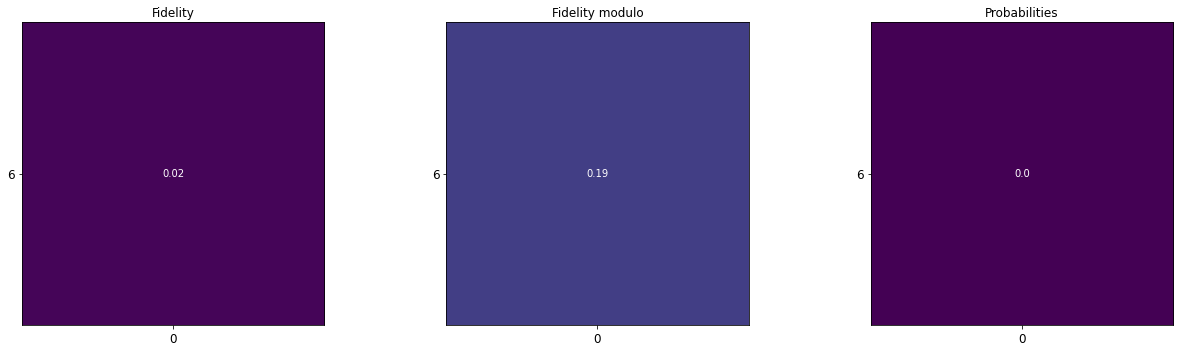

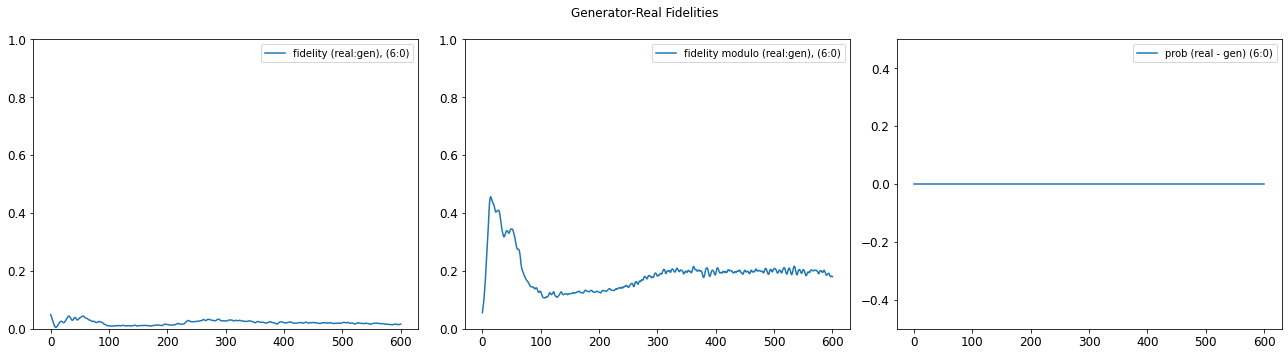

----------------------------------------------------
Epoch 600:  EM distance = 1.0809104265018403, trace distance = 0.9919070972228369, abs trace distance = 0.9055625132776582
h=Z((0, 0))*Y((0, 4)), w=-0.9999999992617585, e=-0.32162702083587646
h=Y((0, 1))*X((0, 3)), w=-0.9999999959382133, e=-0.6168773770332336
h=Z((0, 2)), w=-0.9999999992024254, e=-0.14240603148937225
-------------------------------------
----------- TRAINING DONE -----------


In [550]:
trainers, training_results = run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     real_expectations_provider,
                     rank,
                     epochs,
                     gen_iteration, 
                     snapshot_interval_epochs,
                     description,
                     use_neptune,
                     neptune_params,
                     gan_params)

In [507]:
compute_known_states_stats(trainers[g_values[0]], known_g_values)

{'min_fidelity': 0.00921722901054528,
 'min_fidelity_tuple': (22, 24),
 'max_fidelity': 0.983372412293452,
 'max_fidelity_tuple': (4, 5),
 'average_fidelity': 0.4774584412082613,
 'std_fidelity': 0.22615169385161127}

In [438]:
compute_generated_states_stats(trainers[g_values[0]], known_g_values)

{'min_fidelity': 0.07080615912628119,
 'min_fidelity_tuple': ('GENERATED', 14),
 'max_fidelity': 0.9391769881121945,
 'max_fidelity_tuple': ('GENERATED', 30),
 'average_fidelity': 0.367691368310768,
 'std_fidelity': 0.21347957427372133}

In [344]:
eps = 1.e-6
trainer = trainers[g_values[0]]
re_exps = trainer.real_expectations_provider.get_expectations_for_parameters([g_values[0]])[g_values[0]]
sorted({str(s): e for s, e in re_exps.items() if abs(e) > eps}.items())

[('X((0, 0))', 0.14754534),
 ('X((0, 0))*X((0, 1))', 0.75924635),
 ('X((0, 0))*X((0, 2))', -0.42626035),
 ('X((0, 0))*Y((0, 1))', -0.12668788),
 ('X((0, 0))*Y((0, 2))', -0.7206682),
 ('X((0, 0))*Z((0, 1))', 0.3088193),
 ('X((0, 0))*Z((0, 2))', 0.6731498),
 ('X((0, 1))*Y((0, 2))', -0.8430514),
 ('X((0, 1))*Z((0, 2))', -0.14286077),
 ('Y((0, 0))', 0.30544138),
 ('Y((0, 0))*X((0, 1))', -0.40979004),
 ('Y((0, 0))*X((0, 2))', -0.6717109),
 ('Y((0, 0))*Y((0, 1))', -0.43766254),
 ('Y((0, 0))*Y((0, 2))', 0.026830554),
 ('Y((0, 0))*Z((0, 1))', 0.06405842),
 ('Y((0, 0))*Z((0, 2))', 0.2169596),
 ('Y((0, 1))', 0.67322993),
 ('Y((0, 1))*Y((0, 2))', 0.6540973),
 ('Y((0, 1))*Z((0, 2))', -0.15719438),
 ('Y((0, 2))', -0.46097302),
 ('Z((0, 0))', 0.20179927),
 ('Z((0, 0))*X((0, 1))', 0.042109847),
 ('Z((0, 0))*Y((0, 1))', -0.8732868),
 ('Z((0, 0))*Y((0, 2))', 0.030829906),
 ('Z((0, 0))*Z((0, 1))', 0.63018084),
 ('Z((0, 0))*Z((0, 2))', -0.81903267),
 ('Z((0, 1))', -0.7496703),
 ('Z((0, 1))*Y((0, 2))', 0.

In [345]:
index = 15
trainer.real_expectations_provider.precomputed_expectations_provider.eps = eps
real_exps2 = trainer.real_expectations_provider.precomputed_expectations_provider.get_expectations_for_parameters([index], filter_small_expectations=True)[index]
real_exps2 = {str(k): v for k, v in real_exps2.items()}
sorted(real_exps2.items())

[('X((0, 0))', 0.23629664),
 ('X((0, 0))*X((0, 1))', -0.047355246),
 ('X((0, 0))*X((0, 2))', 0.13211764),
 ('X((0, 0))*Y((0, 1))', 0.24875379),
 ('X((0, 0))*Y((0, 2))', -0.642994),
 ('X((0, 0))*Z((0, 1))', -0.12700395),
 ('X((0, 0))*Z((0, 2))', -0.02755905),
 ('X((0, 1))*Y((0, 2))', -0.008481029),
 ('X((0, 1))*Z((0, 2))', 0.19787562),
 ('Y((0, 0))', -0.05215015),
 ('Y((0, 0))*X((0, 1))', 0.12673008),
 ('Y((0, 0))*X((0, 2))', 0.5986357),
 ('Y((0, 0))*Y((0, 1))', 0.026573643),
 ('Y((0, 0))*Y((0, 2))', 0.14190742),
 ('Y((0, 0))*Z((0, 1))', 0.10182255),
 ('Y((0, 0))*Z((0, 2))', 0.0060821995),
 ('Y((0, 1))', 0.60748446),
 ('Y((0, 1))*Y((0, 2))', -0.23451075),
 ('Y((0, 1))*Z((0, 2))', 0.26279813),
 ('Y((0, 2))', -0.391519),
 ('Z((0, 0))', -0.62009),
 ('Z((0, 0))*X((0, 1))', -0.21292841),
 ('Z((0, 0))*Y((0, 1))', -0.29306725),
 ('Z((0, 0))*Y((0, 2))', 0.2672922),
 ('Z((0, 0))*Z((0, 1))', 0.6590886),
 ('Z((0, 0))*Z((0, 2))', -0.91955674),
 ('Z((0, 1))', -0.6707083),
 ('Z((0, 1))*Y((0, 2))', 0.

In [346]:
gen_exps = list(zip(trainer.disc_hamiltonians, trainer.get_all_generator_expectations(trainer.disc_hamiltonians).numpy()[0]))
sorted({str(s): e for s, e in gen_exps if abs(e) > eps}.items())

[('X((0, 0))', 0.10157645),
 ('X((0, 0))*X((0, 1))', 0.07695043),
 ('X((0, 0))*X((0, 2))', -0.53464466),
 ('X((0, 0))*Y((0, 1))', 0.25167096),
 ('X((0, 0))*Y((0, 2))', 0.104152866),
 ('X((0, 0))*Z((0, 1))', 0.059586424),
 ('X((0, 0))*Z((0, 2))', 0.27349055),
 ('X((0, 1))*Y((0, 2))', -0.49994034),
 ('X((0, 1))*Z((0, 2))', 0.19039133),
 ('Y((0, 0))', -0.19787115),
 ('Y((0, 0))*X((0, 1))', 0.13179865),
 ('Y((0, 0))*X((0, 2))', -0.27445784),
 ('Y((0, 0))*Y((0, 1))', -0.17500073),
 ('Y((0, 0))*Y((0, 2))', -0.20289005),
 ('Y((0, 0))*Z((0, 1))', 0.23162311),
 ('Y((0, 0))*Z((0, 2))', -0.53276026),
 ('Y((0, 1))', 0.51393545),
 ('Y((0, 1))*Y((0, 2))', 0.016313776),
 ('Y((0, 1))*Z((0, 2))', 0.18466671),
 ('Y((0, 2))', -0.10938808),
 ('Z((0, 0))', -0.26575512),
 ('Z((0, 0))*X((0, 1))', -0.5704291),
 ('Z((0, 0))*Y((0, 1))', -0.05382213),
 ('Z((0, 0))*Y((0, 2))', 0.84360063),
 ('Z((0, 0))*Z((0, 1))', 0.5109514),
 ('Z((0, 0))*Z((0, 2))', -0.41997027),
 ('Z((0, 1))', -0.46598166),
 ('Z((0, 1))*Y((0, 2

In [327]:
trainer.gen_evaluator.get_state_from_params()[1]

array([0.01334328, 0.5410961 , 0.00707353, 0.28684464, 0.21145125,
       0.05067034, 0.7389662 , 0.17707941], dtype=float32)

In [328]:
trainer.real_evaluator.get_state_from_params(labels=0)[1]

array([0.03883622, 0.5739804 , 0.02398222, 0.35444552, 0.19726938,
       0.04196318, 0.693121  , 0.14744084], dtype=float32)

In [176]:
cirq.fidelity(trainer.gen_evaluator.get_state_from_params()[1], trainer.real_evaluator.get_state_from_params(labels=-0.3)[1])

0.8418850364998889

In [275]:
np.set_printoptions(suppress=True)
xd = (trainer.get_all_generator_expectations(trainer.disc_hamiltonians).numpy() - trainer.get_real_expectation(
            trainer.disc_hamiltonians)).flatten()
xd

-0.3081206977367401

In [259]:
xdd = np.array([x for pair in zip(xd[0], -xd[0]) for x in pair])

In [260]:
A = np.array([[x for pair in zip(A_i, A_i) for  x in pair] for A_i in trainer.A])

In [261]:
from scipy.optimize import linprog
b = np.ones(len(trainer.qubit_to_string_index))
b

array([1., 1., 1.])

In [267]:
res = linprog(-xdd, A_ub=A, b_ub=b)
res

     con: array([], dtype=float64)
     fun: -2.6711249338111274
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([-0.00000002, -0.00000002, -0.00000002])
  status: 0
 success: True
       x: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        ,

In [273]:
xs = [res.x[i] - res.x[i+1] for i in range(0, len(res.x), 2)]
[el if el > 0.001 else 0 for el in xs]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.9999999996463902,
 0,
 0,
 0,
 0,
 0,
 0.9999999922902141,
 0,
 0]